# Helix colour scheme
---
This notebook relies on the [```colourspace```](https://github.com/gillesferrand/colourspace) package.

Here we are revisiting the "cubehelix" colour scheme by Dave Green<br> http://www.mrao.cam.ac.uk/~dag/CUBEHELIX/<br>
The main requirement is to be perceived as monotonically increasing in lightness from zero to max, so that it works in greyscale, while still going through all the possible hues (in their natural order, possibly repeating them), with some adjustable saturation. We are effectively drawing a tappered helix in colour space along the L axis.

In [1]:
from colourspace import maps

convertor = 'custom' (illuminant = 'D65')


In [2]:
import numpy as np
%matplotlib inline

png_dir = "./maps"

figsize_x = 12
figsize_y = 1.1
dpi = 200

writing  ./maps/cmap256_cubehelix.png


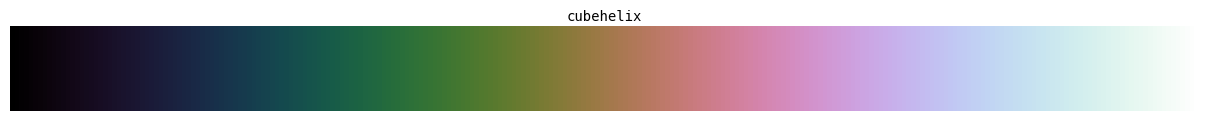

In [3]:
maps.plot_cmaps(names=["cubehelix"],figsize=(figsize_x,figsize_y),labels="top",title="",fname_all="",dir=png_dir)

D. G. default implementation starts in the blues and makes one and a half hue turns backwards, at a moderate saturation that allows colours to show without getting clipped.

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_sRGB.npy


/Users/gferrand/simus/colour/colourspace/gamut.py:357: RuntimeWarning: invalid value encountered in cast
  j0 = (np.floor(j)).astype(int)


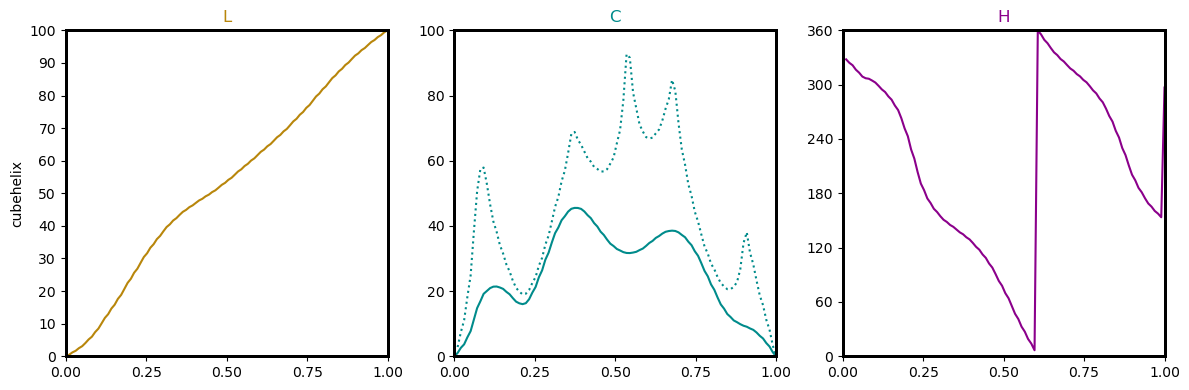

In [4]:
axes = maps.plot_path("cubehelix", space='LCH', stack='H', title="cubehelix")

The cmap having been designed in RGB, the L and H variations are not as uniform as was hoped for.

Working in the cylindrical space HCL, it is trivial to parametrize the path coordinate by coordinate. <br>
\- ```L``` varies linearly from ```0``` to ```100``` (it can optionaly be biased by a "gamma factor"). <br>
\- ```H``` varies linearly from some start point ```H_start```, for a certain number of (oriented) turns ```H_rot```. <br>
\- ```C``` is anchored to 0 at both end points, reaching some maximum value ```C_max``` say in the middle. If the path wanders too far from the neutral axis for a given ```L```, ```H``` pair, some clipping may occur so that it stays in gamut. For simplicity, we can take the path to be symmetric as a function of ```L```. A simple version is made of two linear segments. A smoother version can be obtained by raising the ramps to some power, or by using an arc of a circle. 

In [5]:
# these functions map x in [-1,+1] to y in [0,1]
# they satisfy y(±1)=0 and y(0)=1
def pointy(x,g=1):
    return (1-np.abs(x))**g
def roundy(x):
    return np.sin(np.arccos(x))

func = {}
func["pointy"] = lambda x: pointy(x,g=1.)
func["curvy2"] = lambda x: pointy(x,g=1./2)
func["curvy3"] = lambda x: pointy(x,g=1./3)
func["roundy"] = roundy
functions = ["pointy", "curvy2", "curvy3", "roundy"]

In [6]:
%matplotlib inline
import pylab as plt

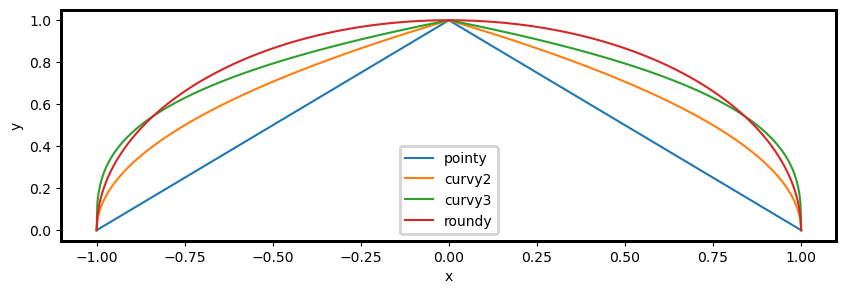

In [7]:
x = np.linspace(-1,+1,1000)
plt.figure(figsize=(10,3))
plt.xlabel('x')
plt.ylabel('y')
for name in functions:
    plt.plot(x,func[name](x),label=name)
plt.legend()

So we get the following custom map-making function:

In [8]:
from colourspace import convert, gamut

In [9]:
def make_cmap_helix(H_start=0, H_rot=1, C_max=50, C_shape="roundy", N=1024, name=""):
    """Makes a cmap by drawing a tappered helix along the L axis, with `N` steps
       L ranges from 0 to 100
       H starts at `H_start` and makes `H_rot` turns around the hue circle
       C peaks at `C_max` with a shape defined by the function named `C_shape` in our library
    """
    
    # draw path
    L = np.linspace(0,100,N)
    H = np.linspace(H_start,H_start+360*H_rot,N)
    C_maxmax = gamut.Cmax_for_LH(L,H,gmt='sRGB')
    if C_shape=="gamut": 
        C = C_maxmax
    else: 
        C = func[C_shape]((L-50)/50.) * C_max
        C = np.minimum(C,C_maxmax)
    
    # make cmap
    RGB = convert.clip3(convert.LCH2RGB(L,C,H))
    if name=="": name = 'helix_H%i%+.1f_C%s%s'%(H_start,H_rot,C_max,C_shape)
    maps.generate_cmaps(RGB, name, targets=['mpl']) # this is a wrapper to matplotlib.colors.ListedColormap(RGB,name)
    return name # the cmap is registered by name in maps.CMAP

Let's try it with our different shapes for C:

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res1_sRGB.npy
creating cmap 'helix_H330-1.5_C40pointy' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.5_C40curvy2' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.5_C40curvy3' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.5_C40roundy' for Matplotlib (1024 steps)
writing  ./maps/cmap256_helix_H330-1.5_C40pointy.png
writing  ./maps/cmap256_helix_H330-1.5_C40curvy2.png
writing  ./maps/cmap256_helix_H330-1.5_C40curvy3.png
writing  ./maps/cmap256_helix_H330-1.5_C40roundy.png


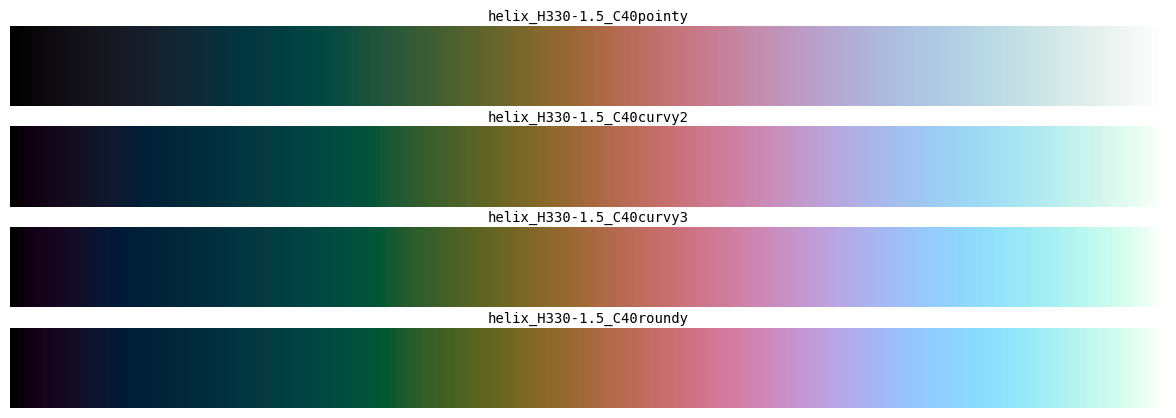

In [10]:
names1 = []
for shape in functions:
    name = make_cmap_helix(H_start=330, H_rot=-1.5, C_max=40, C_shape=shape)
    names1 += [name]

maps.plot_cmaps(names=names1,figsize=(figsize_x,figsize_y*len(names1)),labels="top",title="",fname_all="",dir=png_dir)

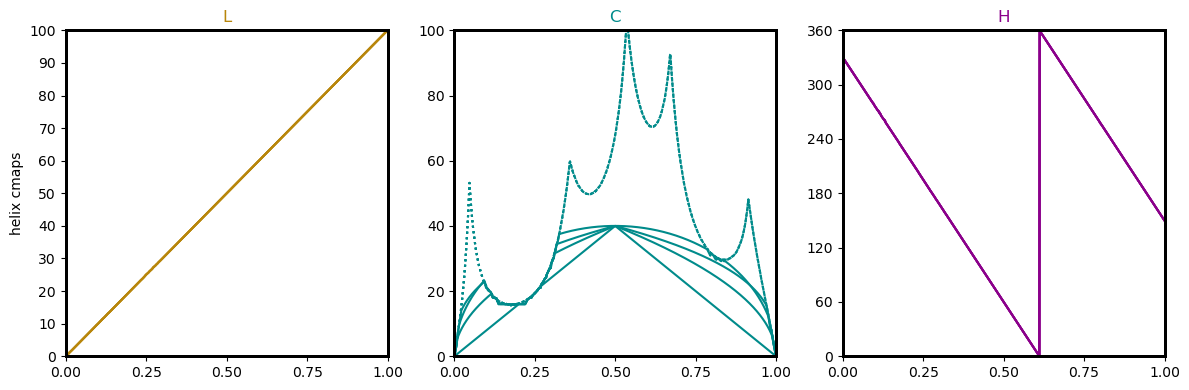

In [11]:
axes = []
for name in names1:
    axes = maps.plot_path(name, space='LCH', stack='H', axes=axes, title="helix cmaps")

We can boost the chroma to some extent:

creating cmap 'helix_H330-1.5_C40roundy' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.5_C60roundy' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.5_C80roundy' for Matplotlib (1024 steps)
writing  ./maps/cmap256_helix_H330-1.5_C40roundy.png
writing  ./maps/cmap256_helix_H330-1.5_C60roundy.png
writing  ./maps/cmap256_helix_H330-1.5_C80roundy.png


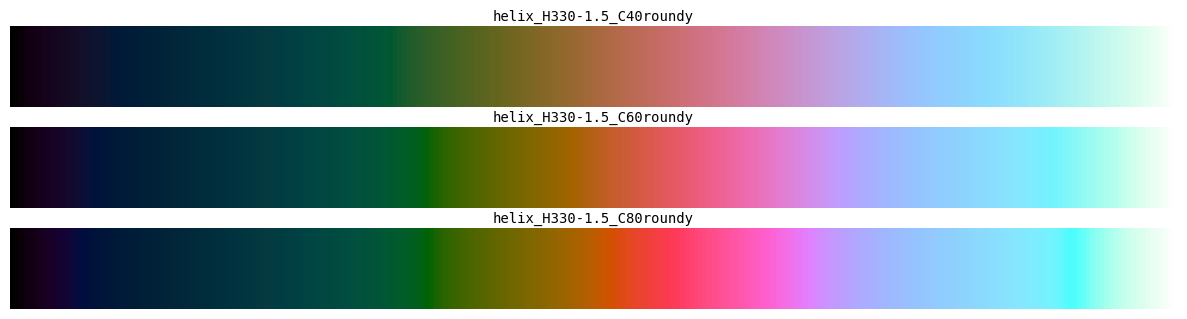

In [12]:
names2 = []
for C_max in [40, 60, 80]:
    name = make_cmap_helix(H_start=330, H_rot=-1.5, C_max=C_max, C_shape="roundy")
    names2 += [name]

maps.plot_cmaps(names=names2,figsize=(figsize_x,figsize_y*len(names2)),labels="top",title="",fname_all="",dir=png_dir)

creating cmap 'helix_H330-1.5_Cgamut' for Matplotlib (1024 steps)
writing  ./maps/cmap256_helix_H330-1.5_Cgamut.png


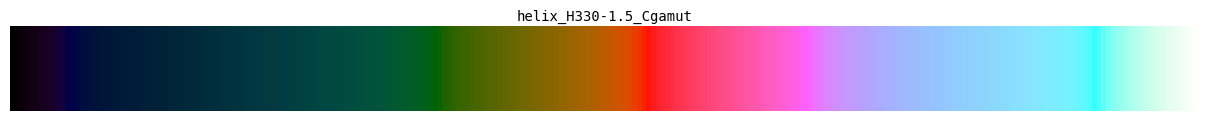

In [13]:
name = make_cmap_helix(H_start=330, H_rot=-1.5, C_max="", C_shape="gamut")
names2 += [name]

maps.plot_cmaps(names=[name],figsize=(figsize_x,figsize_y),labels="top",title="",fname_all="",dir=png_dir)

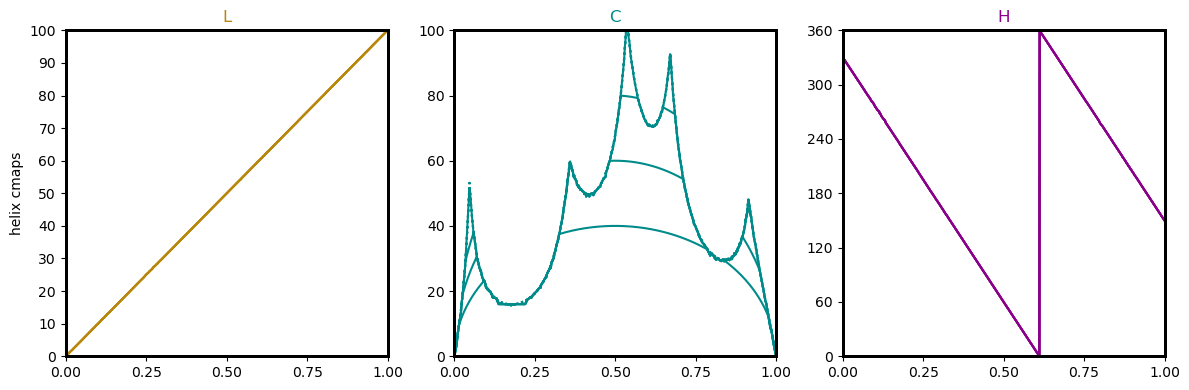

In [14]:
axes = []
for name in names2:
    axes = maps.plot_path(name, space='LCH', stack='H', axes=axes, title="helix cmaps")

We can restrict the hue range as desired:

creating cmap 'helix_H330-1.5_C40roundy' for Matplotlib (1024 steps)
creating cmap 'helix_H330-1.0_C40roundy' for Matplotlib (1024 steps)
creating cmap 'helix_H330-0.7_C40roundy' for Matplotlib (1024 steps)
writing  ./maps/cmap256_helix_H330-1.5_C40roundy.png
writing  ./maps/cmap256_helix_H330-1.0_C40roundy.png
writing  ./maps/cmap256_helix_H330-0.7_C40roundy.png


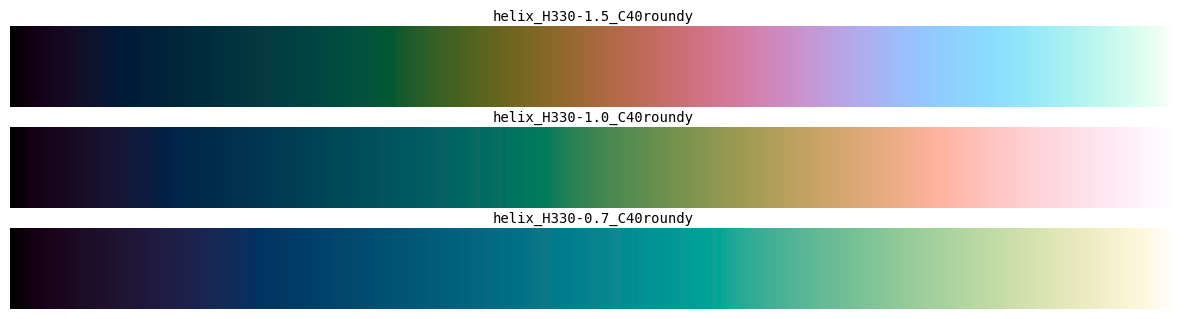

In [15]:
names3 = []
for H_rot in [-1.5, -1.0, -2/3.]:
    name = make_cmap_helix(H_start=330, H_rot=H_rot, C_max=40, C_shape="roundy")
    names3 += [name]

maps.plot_cmaps(names=names3,figsize=(figsize_x,figsize_y*len(names3)),labels="top",title="",fname_all="",dir=png_dir)

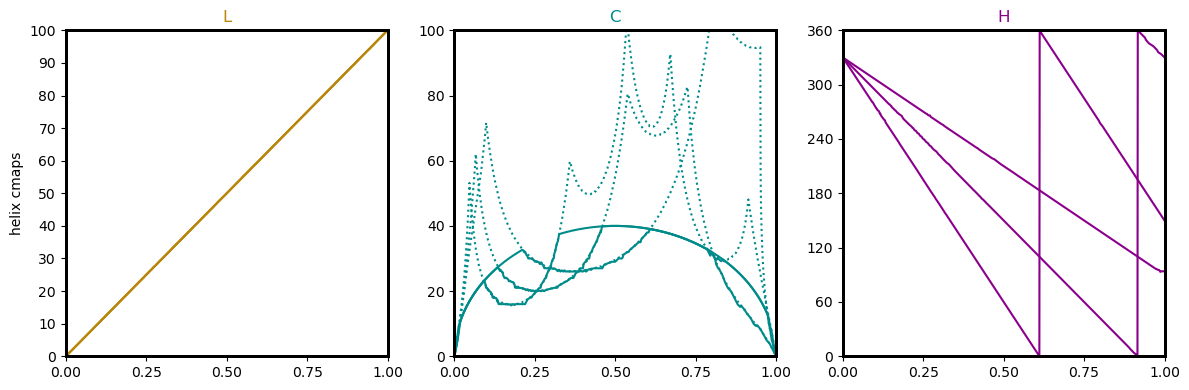

In [16]:
axes = []
for name in names3:
    axes = maps.plot_path(name, space='LCH', stack='H', axes=axes, title="helix cmaps")

All versions for comparison:

writing  ./maps/cmap256_cubehelix.png
writing  ./maps/cmap256_helix_H330-1.5_C40pointy.png
writing  ./maps/cmap256_helix_H330-1.5_C40curvy2.png
writing  ./maps/cmap256_helix_H330-1.5_C40curvy3.png
writing  ./maps/cmap256_helix_H330-1.5_C40roundy.png
writing  ./maps/cmap256_helix_H330-1.5_C60roundy.png
writing  ./maps/cmap256_helix_H330-1.5_C80roundy.png
writing  ./maps/cmap256_helix_H330-1.5_Cgamut.png
writing  ./maps/cmap256_helix_H330-1.0_C40roundy.png
writing  ./maps/cmap256_helix_H330-0.7_C40roundy.png
writing  ./maps/cmaps_helix colour maps.png


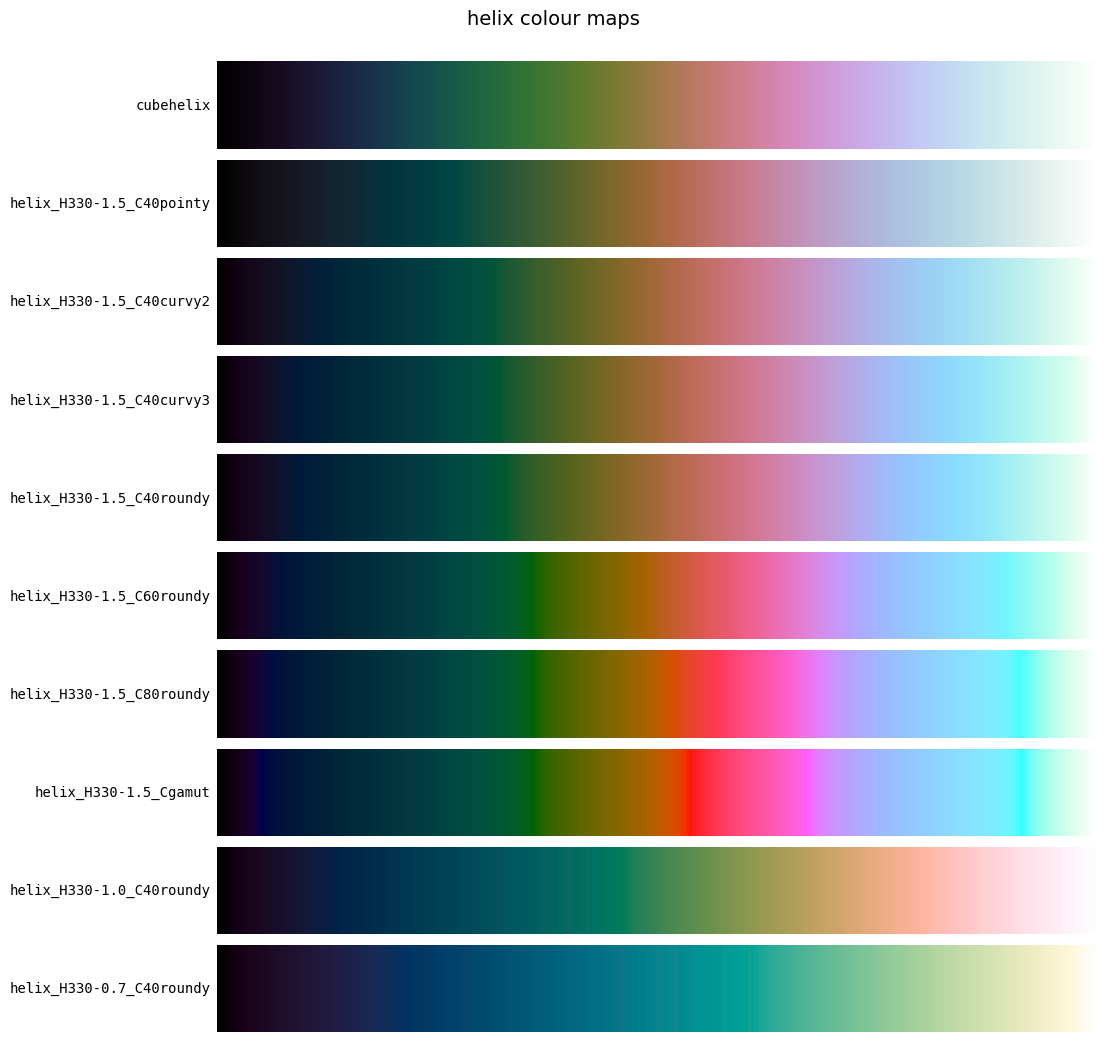

In [17]:
names_all = ['cubehelix'] + names1 + names2[1:] + names3[1:]
maps.plot_cmaps(names=names_all,figsize=(figsize_x,figsize_y*len(names_all)),dpi=dpi,title="helix colour maps",dir=png_dir)

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2020-08-18